Mega merged neural network baseline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import sys
import datetime
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import time

import keras
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import backend

In [2]:
#link google drive and set path. Only necessary if using Google drive to store code and data.

drive.mount('/content/drive/')

#hardcoded for Justin Parsons' environment
sys.path.append('/content/drive/MyDrive/GHG/')
sys.path.append('/content/drive/MyDrive/GHG/Code/')
sys.path.append('/content/drive/MyDrive/GHG/Data/')

#path to data from API calls
path = "/content/drive/MyDrive/GHG/Data/"

#import data into dataframe

df = pd.read_csv(path + "Mega_merged_all_real_values.csv") #data from MM

Mounted at /content/drive/


<ipython-input-2-4980ee199ae5>:15: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + "Mega_merged_all_real_values.csv") #data from MM


In [3]:
df['random_uniform'] = np.random.rand(len(df)) # uniform dist
df['random_normal'] = np.random.randn(len(df)) # normal dist

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181156 entries, 0 to 181155
Data columns (total 44 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_id                    181156 non-null  int64  
 1   account_name                  181156 non-null  object 
 2   incorporated_country          181156 non-null  object 
 3   ticker                        117989 non-null  object 
 4   Evaluation_status             180307 non-null  object 
 5   Scope_3_emissions_type        181156 non-null  object 
 6   Scope_3_emissions_amount      181156 non-null  float64
 7   Symbol_1                      181156 non-null  object 
 8   Year                          181156 non-null  int64  
 9   Market_Cap                    115901 non-null  float64
 10  Employee_Count                23397 non-null   float64
 11  ebitda                        118470 non-null  float64
 12  Revenue                       118470 non-nul

In [5]:
# Replace 0 with 'unclassified' in 'sector', 'industry', and 'activity' columns
df['Primary sector'] = df['Primary sector'].fillna('Unclassified')
df['Primary industry'] = df['Primary industry'].fillna('Unclassified')
df['Primary activity'] = df['Primary activity'].fillna('Unclassified')
df['Primary sector'] = df['Primary sector'].replace('0', 'unclassified')
df['Primary industry'] = df['Primary industry'].replace('0', 'unclassified')
df['Primary activity'] = df['Primary activity'].replace('0', 'unclassified')
df['Employee_Count'] = df['Employee_Count'].replace('0', 'unclassified')

#Drop any companies with revenues and number of employees equal to 0
df = df[df['Revenue'] > 0]

# Clean incoporated country column
df['incorporated_country'] = df['incorporated_country'].replace('Ã…land Islands', 'Finland')
df['incorporated_country'] = df['incorporated_country'].replace('China, Hong Kong Special Administrative Region', 'China')
df['incorporated_country'] = df['incorporated_country'].replace('China, Macao Special Administrative Region', 'China')
df['incorporated_country'] = df['incorporated_country'].replace('Czechia', 'Czech Republic')
df['incorporated_country'] = df['incorporated_country'].replace('Faroe Islands', 'Denmark')
df['incorporated_country'] = df['incorporated_country'].replace('Guernsey', 'United Kingdom')
df['incorporated_country'] = df['incorporated_country'].replace('Hong Kong', 'China')
df['incorporated_country'] = df['incorporated_country'].replace('Isle of Man', 'United Kingdom')
df['incorporated_country'] = df['incorporated_country'].replace('Jersey', 'United Kingdom')
df['incorporated_country'] = df['incorporated_country'].replace('Norfolk Island', 'Australia')
df['incorporated_country'] = df['incorporated_country'].replace('Republic of Korea', 'South Korea')
df['incorporated_country'] = df['incorporated_country'].replace('Russian Federation', 'Russia')
df['incorporated_country'] = df['incorporated_country'].replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')
df['incorporated_country'] = df['incorporated_country'].replace('United States Minor Outlying Islands', 'USA')
df['incorporated_country'] = df['incorporated_country'].replace('Venezuela (Bolivarian Republic of)', 'Venezuela')
df['incorporated_country'] = df['incorporated_country'].replace('Viet Nam', 'Vietnam')

<ipython-input-5-ca212d2f1d5b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['incorporated_country'] = df['incorporated_country'].replace('Ã…land Islands', 'Finland')


In [6]:
#Map countries to new region column
country_to_region = {
    'United Kingdom': 'Europe',
    'USA': 'North America',
    'Italy': 'Europe',
    'India': 'Asia',
    'Spain': 'Europe',
    'France': 'Europe',
    'Switzerland': 'Europe',
    'Netehrlands': 'Europe',
    'Japan': 'Asia',
    'South Africa': 'Africa',
    'Canada': 'North America',
    'New Zealand': 'Oceania',
    'Turkey': 'Asia',
    'Germany': 'Europe',
    'Australia': 'Oceania',
    'Luxembourg': 'Europe',
    'Taiwan': 'Asia',
    'Norway': 'Europe',
    'Sweden': 'Europe',
    'Austria': 'Europe',
    'Brazil': 'South America',
    'Portugal': 'Europe',
    'China': 'Asia',
    'Singapore': 'Asia',
    'South Korea': 'Asia',
    'Russia': 'Europe',
    'Denmark': 'Europe',
    'Ireland': 'Europe',
    'Belgium': 'Europe',
    'Finland': 'Europe',
    'Poland': 'Europe',
    'Malaysia': 'Asia',
    'Mexico': 'North America',
    'Thailand': 'Asia',
    'Vietnam': 'Asia',
    'Philippines': 'Asia',
    'Indonesia': 'Asia',
    'Greece': 'Europe',
    'Chile': 'South America',
    'Argentina': 'South America',
    'Peru': 'South America',
    'Colombia': 'South America',
    'Ecuador': 'South America',
    'Uruguay': 'South America',
    'Paraguay': 'South America',
    'Bolivia': 'South America',
    'Venezuela': 'South America',
    'Panama': 'North America',
    'Costa Rica': 'North America',
    'Honduras': 'North America',
    'El Salvador': 'North America',
    'Nicaragua': 'North America',
    'Guatemala': 'North America',
    'Belize': 'North America',
    'Hungary': 'Europe',
    'Israel': 'Asia',
    'Cyprus': 'Europe',
    'United Arab Emirates': 'Asia',
    'Bermuda': 'North America',
    'Poland': 'Europe',
    'Iceland': 'Europe',
    'Indonesia': 'Asia',
    'Czech Republic': 'Europe',
    'Cayman Islands': 'North America',
    'Egypt': 'Africa',
    'Saudi Arabia': 'Asia',
    'Qatar': 'Asia',
    'Malaysia': 'Asia',
    'Cambodia': 'Asia',
    'Estonia': 'Europe',
    'Marshall Islands': 'Oceania',
    'Ukraine': 'Europe',
    'Lithuania': 'Europe'
}

df['region'] = df['incorporated_country'].map(country_to_region)

In [7]:
#Drop columns that are not needed for the model

df = df.drop(['ebitda',
'Primary questionnaire sector',
'Revenue',
'grossProfit',
'netIncome',
'reportedCurrency',
'cashAndCashEquivalents',
'shortTermInvestments',
'longTermInvestments',
'totalAssets',
'totalLiabilities',
'totalInvestments',
'totalDebt',
'totalEquity',
'account_id',
'account_name',
'ticker',
'Symbol_1',
'Year',
'Market_Cap'], axis=1)

df.dropna(inplace=True)
len(df)

22809

In [8]:
# Industry DF dictionary which contains sub-dictionaries for each unique value in the 'Scope 3 Emissions Type' column
unique_values = df['Primary industry'].unique()

industry_dfs = {}

for value in unique_values:
    filtered_df = df[df['Primary industry'] == value]
    filtered_df = filtered_df.drop(columns=[ 'Primary industry'])
    industry_dfs[value] = filtered_df

dfs_by_emissions_type = {}

# Loop through each DataFrame in 'industry_dfs'
for key, df in industry_dfs.items():
    # Initialize a sub-dictionary for this DataFrame
    sub_dict = {}

    # Find unique values in the 'scope_3_emissions_type' column
    unique_emissions_types = df['Scope_3_emissions_type'].unique()

    # For each unique value, create a sub-DataFrame, drop the 'Scope_3_emissions_type' column, and store it in the sub-dictionary
    for emissions_type in unique_emissions_types:
        filtered_df = df[df['Scope_3_emissions_type'] == emissions_type]
        sub_dict[emissions_type] = filtered_df.drop(columns=['Scope_3_emissions_type'])

    # Assign the sub-dictionary to the main dictionary
    dfs_by_emissions_type[key] = sub_dict

for main_key, sub_dict in dfs_by_emissions_type.items():
    for column_name, df in sub_dict.items():

        df = pd.DataFrame(df)

        # Calculate Z-scores of all columns
        z_scores = stats.zscore(df.select_dtypes(include=[np.number]))

        # Define a mask for rows to keep (abs(z) < 2.5)
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores < 2).all(axis=1)

        # Apply the mask to the DataFrame to keep only rows without outliers
        df_clean = df[filtered_entries]

        # Optionally, replace the original DataFrame in the sub-dictionary
        sub_dict[column_name] = df_clean

# Initialize an empty DataFrame for the combined data
df = pd.DataFrame()

# Loop through the main dictionary to access each sub-dictionary
for industry, emissions_dict in dfs_by_emissions_type.items():
    # Loop through each sub-dictionary to access its DataFrames
    for emissions_type, sub_df in emissions_dict.items():
        # Add back the 'Primary industry' and 'Scope_3_emissions_type' columns
        sub_df['Primary industry'] = industry
        sub_df['Scope_3_emissions_type'] = emissions_type
        # Concatenate this sub-DataFrame to the combined DataFrame
        df = pd.concat([df, sub_df], ignore_index=True)

print(df)

      incorporated_country             Evaluation_status  \
0                      USA          Relevant, calculated   
1                      USA          Relevant, calculated   
2                      USA          Relevant, calculated   
3                      USA          Relevant, calculated   
4                      USA          Relevant, calculated   
...                    ...                           ...   
17569                  USA      Not relevant, calculated   
17570                  USA  Relevant, not yet calculated   
17571                  USA          Relevant, calculated   
17572                  USA          Relevant, calculated   
17573                  USA          Relevant, calculated   

       Scope_3_emissions_amount  Employee_Count  \
0                       1706.23        110000.0   
1                      25813.00         11847.0   
2                       5202.00          4524.0   
3                      10486.00          1819.0   
4                      3

I added third party verification here.

In [9]:
import pandas as pd

# Define the convert_to_dummies function if not already defined
def convert_to_dummies(df, columns_to_dummify):
    dummies = pd.get_dummies(df[columns_to_dummify], drop_first=True)
    df = df.drop(columns=columns_to_dummify)
    df = pd.concat([df, dummies], axis=1)
    return df

columns_to_dummify = ['Evaluation_status', 'incorporated_country', 'region', 'Primary activity', 'Primary sector', 'Primary industry', 'Third_party_verification']

unique_emissions_types = df['Scope_3_emissions_type'].unique()

# Initialize an empty dictionary to store the DataFrames
unique_dfs = {}

# Loop through each unique value
for emissions_type in unique_emissions_types:
    # Filter the DataFrame for the current emissions type
    filtered_df = df[df['Scope_3_emissions_type'] == emissions_type]

    # Temporarily store and remove the 'Scope_3_emissions_amount' column
    scope_3_emissions_amount = filtered_df['Scope_3_emissions_amount']
    filtered_df = filtered_df.drop(columns=['Scope_3_emissions_amount', 'Scope_3_emissions_type'])

    # Convert specified columns to dummy variables
    filtered_df = convert_to_dummies(filtered_df, columns_to_dummify)

    # Append the 'Scope_3_emissions_amount' column back to the DataFrame
    filtered_df['Scope_3_emissions_amount'] = scope_3_emissions_amount

    # Store the result in the dictionary
    unique_dfs[emissions_type] = filtered_df

# Access the modified DataFrame for 'Purchased goods and services'
unique_dfs['Purchased goods and services']

,Employee_Count,Revenue_USD,Market_Cap_USD,ebitda_USD,grossProfit_USD,netIncome_USD,cashAndCashEquivalents_USD,shortTermInvestments_USD,longTermInvestments_USD,totalAssets_USD,...,Third_party_verification_Question not applicable,Third_party_verification_Third party verification or assurance complete,Third_party_verification_Third party verification or assurance process in place,Third_party_verification_Third party verification or assurance underway but not yet complete - first year it has taken place,Third_party_verification_Third party verification or assurance underway but not yet complete - last years statement available,Third_party_verification_Third party verification or assurance underway for the reporting year but not yet complete - last year's statement attached,Third_party_verification_Third party verification or assurance underway for the reporting year but not yet complete – previous statement of biennial process attached,Third_party_verification_Third party verification underway but not yet complete – first year it has taken place,Third_party_verification_Third-party verification or assurance process in place,Scope_3_emissions_amount
3526,7300.0,2.312200e+09,1.134693e+10,5.215000e+08,2.073700e+09,247400000.0,1.612200e+09,3.421000e+08,4.111000e+08,4.308400e+09,...,False,True,False,False,False,False,False,False,False,3091.92
3527,6400.0,2.430800e+09,4.730544e+09,3.394000e+08,6.630000e+08,212100000.0,2.660000e+08,0.000000e+00,2.090000e+07,2.018200e+09,...,False,True,False,False,False,False,False,False,False,56982.00
3528,8564.0,2.498000e+09,8.557200e+09,9.640000e+08,2.498000e+09,541000000.0,6.451000e+09,9.419000e+09,9.419000e+09,6.522700e+10,...,False,True,False,False,False,False,False,False,False,3340.00
3529,5000.0,9.403000e+09,7.699774e+09,1.376000e+09,9.403000e+09,560000000.0,4.214000e+09,5.897000e+10,6.104700e+10,1.080450e+11,...,False,False,False,False,False,False,False,False,False,1937.00
3530,18800.0,2.623600e+10,1.629625e+10,5.150000e+08,2.195600e+10,176000000.0,1.428000e+09,6.723300e+10,9.086200e+10,2.778840e+11,...,False,True,False,False,False,False,False,False,False,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17371,4200.0,3.627286e+09,1.715459e+10,7.173820e+08,1.825370e+09,516822000.0,9.817950e+08,0.000000e+00,0.000000e+00,2.556203e+09,...,False,False,False,False,False,False,False,False,True,1140216.00
17372,31000.0,9.217700e+09,7.192868e+09,1.119200e+09,5.363200e+09,663600000.0,7.076000e+08,0.000000e+00,8.100000e+07,1.117290e+10,...,False,False,False,False,False,False,False,False,False,1156986.00
17373,4200.0,1.981582e+09,3.037482e+09,2.344360e+08,8.161060e+08,171554000.0,2.046400e+08,1.517300e+07,0.000000e+00,1.347943e+09,...,False,False,False,False,False,False,False,False,False,396876.26
17374,15230.0,2.945594e+09,2.695468e+09,3.661340e+08,1.395935e+09,232500000.0,3.512130e+08,0.000000e+00,1.730000e+07,2.378613e+09,...,False,False,False,False,False,False,False,False,False,868555.45


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'unique_dfs' and 'Purchased goods and services' key exist
numeric_cols = unique_dfs['Purchased goods and services'].select_dtypes(include=np.number).columns #np.number selects all numeric datatypes
scaler = MinMaxScaler()
unique_dfs['Purchased goods and services'][numeric_cols] = scaler.fit_transform(unique_dfs['Purchased goods and services'][numeric_cols])

In [11]:
unique_dfs['Purchased goods and services'].sample(5)

,Employee_Count,Revenue_USD,Market_Cap_USD,ebitda_USD,grossProfit_USD,netIncome_USD,cashAndCashEquivalents_USD,shortTermInvestments_USD,longTermInvestments_USD,totalAssets_USD,...,Third_party_verification_Question not applicable,Third_party_verification_Third party verification or assurance complete,Third_party_verification_Third party verification or assurance process in place,Third_party_verification_Third party verification or assurance underway but not yet complete - first year it has taken place,Third_party_verification_Third party verification or assurance underway but not yet complete - last years statement available,Third_party_verification_Third party verification or assurance underway for the reporting year but not yet complete - last year's statement attached,Third_party_verification_Third party verification or assurance underway for the reporting year but not yet complete – previous statement of biennial process attached,Third_party_verification_Third party verification underway but not yet complete – first year it has taken place,Third_party_verification_Third-party verification or assurance process in place,Scope_3_emissions_amount
6635,0.002778,0.074342,0.169680,0.186917,0.414138,0.411454,0.043023,0.061440,0.107709,0.037233,...,False,False,False,False,False,False,False,False,True,0.015503
11620,0.000000,0.005920,0.000143,0.066391,0.288605,0.328855,0.001377,0.061273,0.114464,0.001741,...,False,False,False,False,False,False,False,False,False,0.001829
5118,0.020273,0.035614,0.102063,0.174904,0.354531,0.447878,0.023898,0.071212,0.133229,0.030562,...,False,False,False,False,False,False,False,False,False,0.003804
11650,0.006393,0.003112,0.005923,0.071311,0.285436,0.335803,0.005847,0.062910,0.114443,0.002670,...,False,False,False,False,False,False,False,False,False,0.005722
8713,0.046667,0.036357,0.014574,0.115632,0.318111,0.370526,0.004089,0.061268,0.114438,0.008302,...,False,False,False,False,False,False,False,False,True,0.023173


In [12]:
unique_dfs['Purchased goods and services'].describe()

,Employee_Count,Revenue_USD,Market_Cap_USD,ebitda_USD,grossProfit_USD,netIncome_USD,cashAndCashEquivalents_USD,shortTermInvestments_USD,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,random_uniform,random_normal,Scope_3_emissions_amount
count,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000
mean,0.048095,0.054044,0.062870,0.141595,0.337505,0.377314,0.026832,0.081997,0.137760,0.057924,0.045429,0.083007,0.072714,0.241474,0.504244,0.474044,0.028864
std,0.078543,0.066254,0.098348,0.100170,0.079658,0.075035,0.072711,0.092152,0.094419,0.105285,0.094296,0.076132,0.106190,0.111107,0.293634,0.186323,0.071367
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001032,0.016395,0.011771,0.084853,0.295060,0.339668,0.003084,0.061268,0.114465,0.010829,0.006980,0.064198,0.015299,0.174696,0.250434,0.337311,0.000589
50%,0.020611,0.032382,0.028729,0.109730,0.310954,0.354801,0.008392,0.061308,0.115188,0.025194,0.016953,0.064936,0.039120,0.203677,0.508778,0.472416,0.005447
75%,0.057778,0.066837,0.073607,0.156108,0.344037,0.387765,0.021342,0.063857,0.120343,0.058711,0.037855,0.069268,0.081660,0.266803,0.769921,0.608721,0.027027
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


I am only training and testing this model on one emission type for a baseline.

In [13]:
# Split dataset into y targets and remove the targets from the dataset.  We are predicting MPG (fuel efficiencey) so the targets are MPG
train_dataset = unique_dfs['Purchased goods and services'].sample(frac=0.8, random_state=13) #80/20 test and train split
test_dataset = unique_dfs['Purchased goods and services'].drop(train_dataset.index)

train_labels =  train_dataset.pop('Scope_3_emissions_amount')
test_labels = test_dataset.pop('Scope_3_emissions_amount')

In [14]:
train_dataset.shape

(1401, 255)

In [15]:
unique_dfs['Purchased goods and services'].sample()

,Employee_Count,Revenue_USD,Market_Cap_USD,ebitda_USD,grossProfit_USD,netIncome_USD,cashAndCashEquivalents_USD,shortTermInvestments_USD,longTermInvestments_USD,totalAssets_USD,...,Third_party_verification_Question not applicable,Third_party_verification_Third party verification or assurance complete,Third_party_verification_Third party verification or assurance process in place,Third_party_verification_Third party verification or assurance underway but not yet complete - first year it has taken place,Third_party_verification_Third party verification or assurance underway but not yet complete - last years statement available,Third_party_verification_Third party verification or assurance underway for the reporting year but not yet complete - last year's statement attached,Third_party_verification_Third party verification or assurance underway for the reporting year but not yet complete – previous statement of biennial process attached,Third_party_verification_Third party verification underway but not yet complete – first year it has taken place,Third_party_verification_Third-party verification or assurance process in place,Scope_3_emissions_amount
11564,0.0,0.059509,0.01587,0.12065,0.307186,0.354217,0.016743,0.061668,0.116284,0.025735,...,False,False,False,False,False,False,False,False,False,0.143418


Not a good feature space for a low-sample NN. Trying to look at covariance with a threshold >0.01

In [16]:
df = unique_dfs['Purchased goods and services']

# Calculate the covariance matrix
covariance_matrix = df.cov()

# Find feature pairs with covariance > 0.01
high_covariance_pairs = []
for i in range(len(covariance_matrix.columns)):
    for j in range(i + 1, len(covariance_matrix.columns)):
        feature1 = covariance_matrix.columns[i]
        feature2 = covariance_matrix.columns[j]
        covariance_value = covariance_matrix.iloc[i, j]
        if covariance_value > 0.01:
            high_covariance_pairs.append((feature1, feature2, covariance_value))

# Print the results
print("Feature pairs with covariance > 0.01:")
for pair in high_covariance_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]}")

Feature pairs with covariance > 0.01:
shortTermInvestments_USD and Primary sector_Financial services: 0.014228991439466371
shortTermInvestments_USD and Primary industry_Services: 0.013028635730749786
longTermInvestments_USD and Primary sector_Financial services: 0.016962945036155513
longTermInvestments_USD and Primary industry_Services: 0.013754794106764792
totalAssets_USD and Primary activity_Banks: 0.011361525952440776
totalAssets_USD and Primary sector_Financial services: 0.01755613673018172
totalAssets_USD and Primary industry_Services: 0.0167210006705993
totalLiabilities_USD and Primary sector_Financial services: 0.015096111184165711
totalLiabilities_USD and Primary industry_Services: 0.014339982116746962
totalInvestments_USD and Primary sector_Financial services: 0.013030496413285787
totalInvestments_USD and Primary industry_Services: 0.011190055510404577
totalEquity_USD and Primary industry_Services: 0.011139643705434053
Evaluation_status_Relevant, calculated and Third_party_ver

In [21]:

%%time

def build_model():
    model = models.Sequential()
    input_size = train_dataset.shape[1]
    model.add(keras.Input(shape=(input_size,)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) #single neuron for regression with no need for activation function (https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)

    keras.backend.clear_session()
    model.compile(optimizer='adam', loss='mse', metrics=['mae']) #standard selection for regression
    return model

model = build_model()

history = model.fit(train_dataset, train_labels, epochs=10000, validation_split=0.2, verbose=0)

CPU times: user 48min 18s, sys: 2min 31s, total: 50min 49s
Wall time: 49min 56s


In [22]:
hist = pd.DataFrame(history.history)
print(hist.tail())

          loss       mae  val_loss   val_mae
9995  0.000032  0.002252  0.004236  0.023430
9996  0.000014  0.002283  0.004204  0.024056
9997  0.000039  0.002104  0.004189  0.024215
9998  0.000006  0.001527  0.004227  0.024440
9999  0.000017  0.001422  0.004275  0.025422


11/11 - 0s - 10ms/step - loss: 0.0018 - mae: 0.0196
Mean Absolute Error on Test Data: 0.019635086879134178


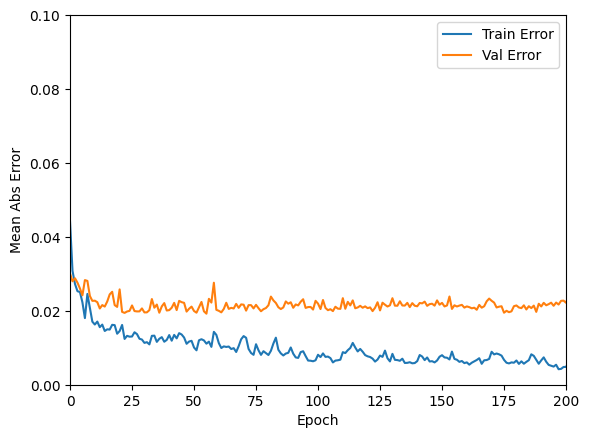

CPU times: user 401 ms, sys: 58.9 ms, total: 460 ms
Wall time: 488 ms


In [23]:
%%time

#Plot the loss and MAE vs epochs
loss, mae = model.evaluate(test_dataset, test_labels, verbose=2)
print(f"Mean Absolute Error on Test Data: {mae}")

# Plot the training history
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
plt.legend()
plt.ylim([0,0.1])
plt.xlim([0,200])
plt.show()

This was just a test but...

Training looks good. MAE starts very low nut this is normalized data.
Validation plateuas indicating high variance and overfitting


-Feature slection
-L1/L2 regularization
-Obviously grid search or permutate on the neural network makeup
-Other network architectures
-

-Add inverted standard scaler MAE/loss